### Split the data on the disk into a train, validation and test set

1. Create for each tile on folder which contains the folder from every season for this tile
2. Random sample tiles for the train, validation and test set
3. Copy the tiles from the disk to the train, validation and test folder

In [1]:
from pathlib import Path
import rasterio
import re
import os
import random
import shutil
import torch
from tqdm import tqdm
from datetime import datetime, date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
IDENTIFIER_REGEX = re.compile(
    r"""(?P<mission>S2[A-B])_MSI
        (?P<product_level>L[1-2][A-C])_
        (?P<sensing_time>\d{8}T\d{6})_
        (?P<processing_baseline>N\d{4})_
        (?P<relative_orbit>R\d{3})_T
        (?P<utm_code>\d{2})
        (?P<latitude_band>\w{1})
        (?P<square>\w{2})_
        (?P<year>\d{4})
        (?P<month>\d{2})
        (?P<day>\d{2})T
        (?P<product_time>\d{6})""",
    re.VERBOSE,
)

In [3]:
def get_tile_and_date(identifier: str):
    regex_match = re.search(IDENTIFIER_REGEX, identifier)

    if not regex_match:
        return None, None

    utm_code = regex_match.group("utm_code")
    latitude_band = regex_match.group("latitude_band")
    square = regex_match.group("square")
    year = regex_match.group("year")
    # remove leading zeros
    month = str(int(regex_match.group("month")))
    day = str(int(regex_match.group("day")))

    tile = f"{utm_code}{latitude_band}{square}"
    tile_date = f"{year}-{month}-{day}"

    return tile, tile_date

In [47]:
images_prepro_path = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\images_only_AOI_test_color_corr_cleaned')
masks_prepro_path = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\masks_only_AOI_test_color_corr_cleaned')

In [8]:
seasons_dict = {"winter":{'start_date':date(2018, 1, 1), 'end_date':date(2018, 3, 31)},
                "spring":{'start_date':date(2018, 4, 1), 'end_date':date(2018, 6, 30)},
                "summer":{'start_date':date(2018, 7, 1), 'end_date':date(2018, 9, 30)},
                "autumn":{'start_date':date(2018, 10, 1), 'end_date':date(2018, 11, 30)}}

### Count number of tiles from each season

In [13]:
# count number of tiles from each season
directory = Path(r"C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\training_data_raw")
tiles_per_season = {"winter": 0, "spring": 0, "summer": 0, "autumn": 0}
# Iterate over the files in the directory
for filename in os.listdir(directory):
    # Extract the tile name and date from the filename
    tile, tile_date = get_tile_and_date(filename)
    if tile is None or tile_date is None:
        continue

    # Convert the date to a datetime object
    tile_datetime = datetime.strptime(tile_date, "%Y-%m-%d").date()

    # Determine the season based on the date
    season = None
    for season_name, season_dates in seasons_dict.items():
        if season_dates['start_date'] <= tile_datetime <= season_dates['end_date']:
            season = season_name
            break

    # If the season was determined, increment the count for that season
    if season is not None:
        tiles_per_season[season] += 1

# Display the number of tiles for each season
total_tiles = sum(tiles_per_season.values())
for season, count in tiles_per_season.items():
    print(f"{season}: {count} tiles")
print(f"Total: {total_tiles} tiles")

winter: 2 tiles
spring: 60 tiles
summer: 77 tiles
autumn: 53 tiles
Total: 192 tiles


## Create a list of all tiles which are available on the disk

In [ ]:
def index_to_filename(image_dir: Path, set_list: list) -> list:
    set_filenames = []
    for file_path in image_dir.glob("*.pt"):
        tile, number, date = file_path.stem.split("_")
        if (tile, number) in set_list:
            set_filenames.append(str(file_path))  # .name
    return set_filenames

In [52]:
# create a list of all tiles
tile_list = []
for file_path in images_prepro_path.glob("*.pt"):
    filename = file_path.stem
    tile, number, date = filename.split("_")
    tile_list.append(tile)

# set is used to get unique values of tiles
tiles_unique = list(set(tile_list))

In [ ]:
# select random tiles for train, val and test
random.seed(42)
random.shuffle(tiles_unique)

num_total = len(tiles_unique)
num_train = int(num_total * 0.7)
num_val = int(num_total * 0.1)

In [54]:
# create train, val and test list
train_list = tiles_unique[:num_train]
val_list = tiles_unique[num_train : num_train + num_val]
test_list = tiles_unique[num_train + num_val :]

In [56]:
# create a directory for each set
train_dir = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\data_splitted')
for set_name in ["train", "val", "test"]:
    os.makedirs(train_dir / set_name, exist_ok=True)
    os.makedirs(train_dir / set_name / "images", exist_ok=True)
    os.makedirs(train_dir / set_name / "masks", exist_ok=True)

In [69]:
for file in images_prepro_path.glob("*.pt"):
    file_stammed = file.stem
    filename = file.name
    tile, _, _ = file_stammed.split("_")
    if tile in train_list:
        shutil.copyfile(images_prepro_path / filename, train_dir / "train" / "images" / filename)
        shutil.copyfile(masks_prepro_path / filename, train_dir / "train" / "masks" / filename)
    elif tile in val_list:
        shutil.copyfile(images_prepro_path / filename, train_dir / "val" / "images" / filename)
        shutil.copyfile(masks_prepro_path / filename, train_dir / "val" / "masks" / filename)
    elif tile in test_list:
        shutil.copyfile(images_prepro_path / filename, train_dir / "test" / "images" / filename)
        shutil.copyfile(masks_prepro_path / filename, train_dir / "test" / "masks" / filename)
    else:
        print("Error: Tile not in any set!")

In [73]:
# check if all files are copied
print("Number of files in each set:")
print(f'Train images: {len(list(train_dir.glob("train/images/*.pt")))}')
print(f'Train masks: {len(list(train_dir.glob("train/masks/*.pt")))}')
print(f'Val images: {len(list(train_dir.glob("val/images/*.pt")))}')
print(f'Val masks: {len(list(train_dir.glob("val/masks/*.pt")))}')
print(f'Test images: {len(list(train_dir.glob("test/images/*.pt")))}')
print(f'Test masks: {len(list(train_dir.glob("test/masks/*.pt")))}')

Number of files in each set:
Train images: 3832
Train masks: 3832
Val images: 489
Val masks: 489
Test images: 342
Test masks: 342


In [ ]:
print("Sum of all files:")
print(f'Images: {len(list(train_dir.glob("**/*.pt")))}')

### Same as before, but now with the undersampled data

### But First EDA about the data

In [27]:
# create histogram of masks sizes in dataset
mask_size_list = []
file_paths_list = []
masks_prepro_path = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\masks_undersampling')
for file_path in masks_prepro_path.glob('*.tif'):
    mask = rasterio.open(file_path).read()
    if mask.sum() > 0:
        mask_size_list.append(mask.sum())
        file_paths_list.append(file_path)

In [28]:
df = pd.DataFrame({'mask_size':mask_size_list, 'file_path':file_paths_list})

In [29]:
mean_mask_size = np.mean(mask_size_list)
median_mask_size = np.median(mask_size_list)

In [30]:
print(f"Max mask size: {max(mask_size_list)}")
print(f"Min mask size: {min(mask_size_list)}")
print(f"Mean mask size: {round(mean_mask_size, 2)}")
print(f"Median mask size: {median_mask_size}")

Max mask size: 20738
Min mask size: 2
Mean mask size: 811.32
Median mask size: 461.0


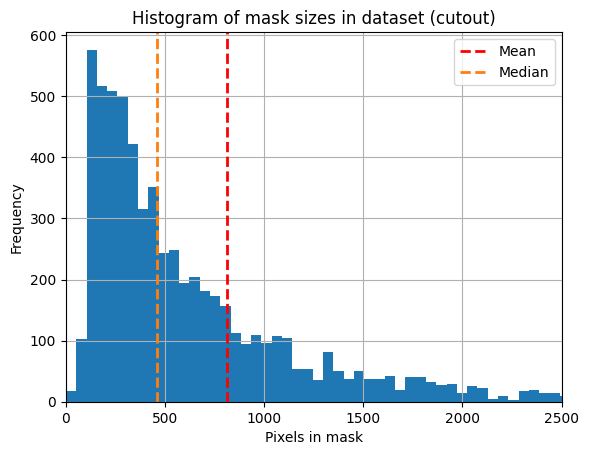

In [39]:
fig, ax = plt.subplots()
ax.hist(mask_size_list, bins=400, )
ax.grid(True)
ax.set_xlim(0, 2500)
ax.set_xlabel('Pixels in mask')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of mask sizes in dataset (cutout)')
ax.axvline(mean_mask_size, color='r', linestyle='dashed', linewidth=2)
ax.axvline(median_mask_size, color='tab:orange', linestyle='dashed', linewidth=2)
ax.legend(['Mean', 'Median']);

In [41]:
fig.savefig('figures/cleaned_verified_data/histogram_mask_size_eng.pdf', bbox_inches='tight')
fig.savefig('figures/cleaned_verified_data/histogram_mask_size_eng.svg', bbox_inches='tight')

In [43]:
df.sort_values(by=['mask_size'], ascending=True, inplace=True)

In [44]:
df.head()

,mask_size,file_path
5979,2,C:\Users\Fabian\Documents\Github_Masterthesis\...
5978,2,C:\Users\Fabian\Documents\Github_Masterthesis\...
2751,3,C:\Users\Fabian\Documents\Github_Masterthesis\...
3154,6,C:\Users\Fabian\Documents\Github_Masterthesis\...
5849,11,C:\Users\Fabian\Documents\Github_Masterthesis\...


Mask size: 88


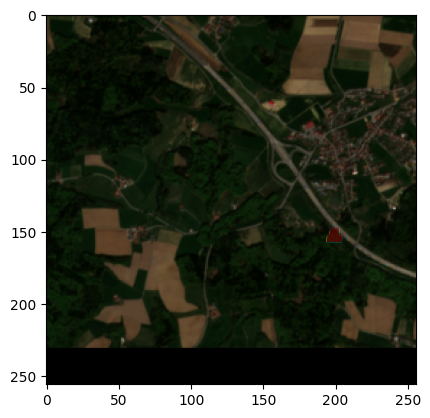

In [45]:
path_to_images = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\images_undersampling')
file_path = df.iloc[45, 1]
image = rasterio.open(path_to_images/file_path.name).read()[1:4, :, :].transpose(1, 2, 0)
mask = rasterio.open(file_path).read()
plt.imshow(image);
plt.imshow(mask[0, :, :], alpha=0.5*(mask[0, :, :] > 0), cmap='jet');
print(f"Mask size: {mask.sum()}")
# plt.ylim(0, 100)
# plt.xlim(50, 150)

Text(0.5, 1.0, 'Mask size: 293')

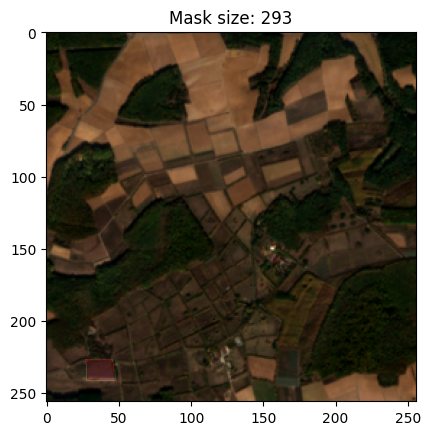

In [78]:
file_path_small_mask = df.iloc[2007, 1]
image_small_mask = rasterio.open(path_to_images/file_path_small_mask.name).read()[1:4, :, :].transpose(1, 2, 0)
small_mask = rasterio.open(file_path_small_mask).read()
plt.imshow(image_small_mask);
plt.imshow(small_mask[0, :, :], alpha=0.3*(small_mask[0, :, :] > 0), cmap='jet',);
plt.title(f"Mask size: {small_mask.sum()}")
# plt.annotate("", (1.5, 5.5))
# plt.ylim(100, 200)
# plt.xlim(150, 250)

In [80]:
file_path_small_mask = df.iloc[53, 1]
image_small_mask = rasterio.open(path_to_images/file_path_small_mask.name).read()[1:4, :, :].transpose(1, 2, 0)
small_mask = rasterio.open(file_path_small_mask).read()

file_path_medium_mask = df.iloc[2007, 1]
image_medium_mask = rasterio.open(path_to_images/file_path_medium_mask.name).read()[1:4, :, :].transpose(1, 2, 0)
medium_mask = rasterio.open(file_path_medium_mask).read()

file_path_large_mask = df.iloc[3004, 1]
image_large_mask = rasterio.open(path_to_images/file_path_large_mask.name).read()[1:4, :, :].transpose(1, 2, 0)
large_mask = rasterio.open(file_path_large_mask).read()

file_path_very_large_mask = df.iloc[3505, 1]
image_very_large_mask = rasterio.open(path_to_images/file_path_very_large_mask.name).read()[1:4, :, :].transpose(1, 2, 0)
very_large_mask = rasterio.open(file_path_very_large_mask).read()

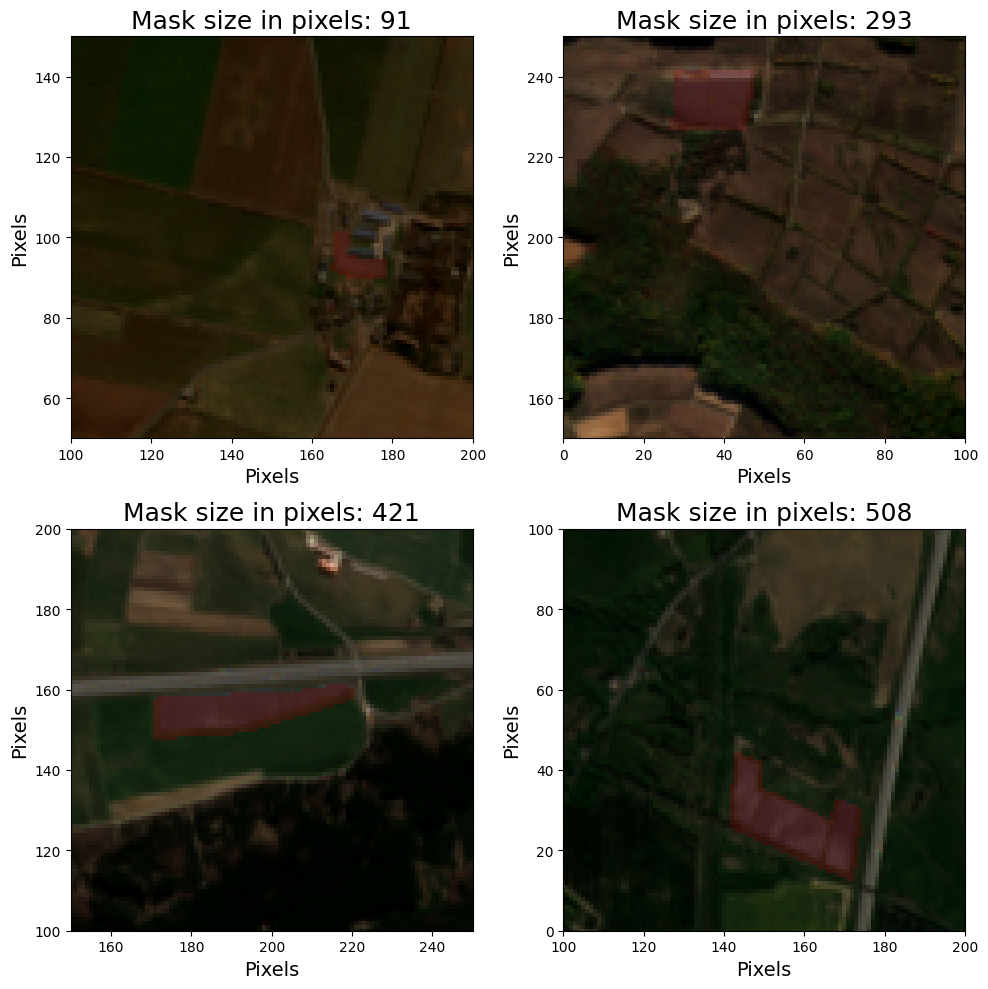

In [84]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
ax1, ax2, ax3, ax4 = axes.flatten()

ax1.imshow(image_small_mask);
ax1.imshow(small_mask[0, :, :], alpha=0.3*(small_mask[0, :, :] > 0), cmap='jet');
ax1.set_title(f"Mask size in pixels: {small_mask.sum()}", fontsize=18)
ax1.set_ylim(50, 150)
ax1.set_xlim(100, 200)
ax1.set_xlabel('Pixels', fontsize=14)
ax1.set_ylabel('Pixels', fontsize=14)

ax2.imshow(image_medium_mask);
ax2.imshow(medium_mask[0, :, :], alpha=0.3*(medium_mask[0, :, :] > 0), cmap='jet');
ax2.set_title(f"Mask size in pixels: {medium_mask.sum()}", fontsize=18)
ax2.set_ylim(150, 250)
ax2.set_xlim(0, 100)
ax2.set_xlabel('Pixels', fontsize=14)
ax2.set_ylabel('Pixels', fontsize=14)

ax3.imshow(image_large_mask);
ax3.imshow(large_mask[0, :, :], alpha=0.3*(large_mask[0, :, :] > 0), cmap='jet');
ax3.set_title(f"Mask size in pixels: {large_mask.sum()}", fontsize=18)
ax3.set_ylim(100, 200)
ax3.set_xlim(150, 250)
ax3.set_xlabel('Pixels', fontsize=14)
ax3.set_ylabel('Pixels', fontsize=14)

ax4.imshow(image_very_large_mask);
ax4.imshow(very_large_mask[0, :, :], alpha=0.3*(very_large_mask[0, :, :] > 0), cmap='jet');
ax4.set_title(f"Mask size in pixels: {very_large_mask.sum()}", fontsize=18)
ax4.set_ylim(0, 100)
ax4.set_xlim(100, 200)
ax4.set_xlabel('Pixels', fontsize=14)
ax4.set_ylabel('Pixels', fontsize=14)

fig.tight_layout()
plt.show()

In [85]:
fig.savefig('figures/raw_data/mask_sizes_images_eng.pdf', bbox_inches='tight')
fig.savefig('figures/raw_data/mask_sizes_images_eng.svg', bbox_inches='tight')

#### Average brightness of image patches

In [86]:
avg_image_brightness_list = []
file_paths_list = []
images_prepro_path = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\images_undersampling')
for file_path in images_prepro_path.glob('*.tif'):
    image = rasterio.open(file_path).read()
    avg_image_brightness_list.append(image.mean())
    file_paths_list.append(file_path)

In [87]:
df = pd.DataFrame({'avg_brightness': avg_image_brightness_list, 'file_path': file_paths_list})

In [88]:
mean_avg_brightness = np.mean(avg_image_brightness_list)
median_avg_brightness  = np.median(avg_image_brightness_list)

In [90]:
print(f"Max image brightness: {max(avg_image_brightness_list):.3f}")
print(f"Min image brightness: {min(avg_image_brightness_list):.3f}")
print(f"Mean image brightness: {mean_avg_brightness:.3f}")
print(f"Median image brightness: {median_avg_brightness:.3f}")

Max image brightness: 0.652
Min image brightness: 0.011
Mean image brightness: 0.246
Median image brightness: 0.233


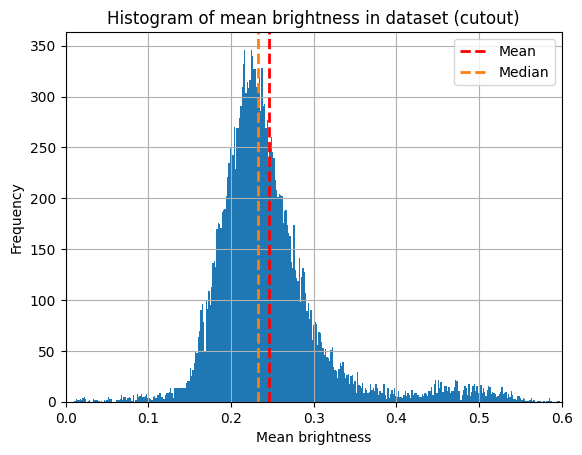

In [94]:
fig, ax = plt.subplots()
ax.hist(avg_image_brightness_list, bins=400)
ax.grid(True)
ax.set_xlim(0, 0.60)
ax.set_xlabel('Mean brightness')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of mean brightness in dataset (cutout)')
ax.axvline(mean_avg_brightness, color='r', linestyle='dashed', linewidth=2)
ax.axvline(median_avg_brightness, color='tab:orange', linestyle='dashed', linewidth=2)
ax.legend(['Mean', 'Median']);

In [95]:
fig.savefig('figures/raw_data/histogram_brightness_eng.pdf', bbox_inches='tight')
fig.savefig('figures/raw_data/histogram_brightness_eng.svg', bbox_inches='tight')

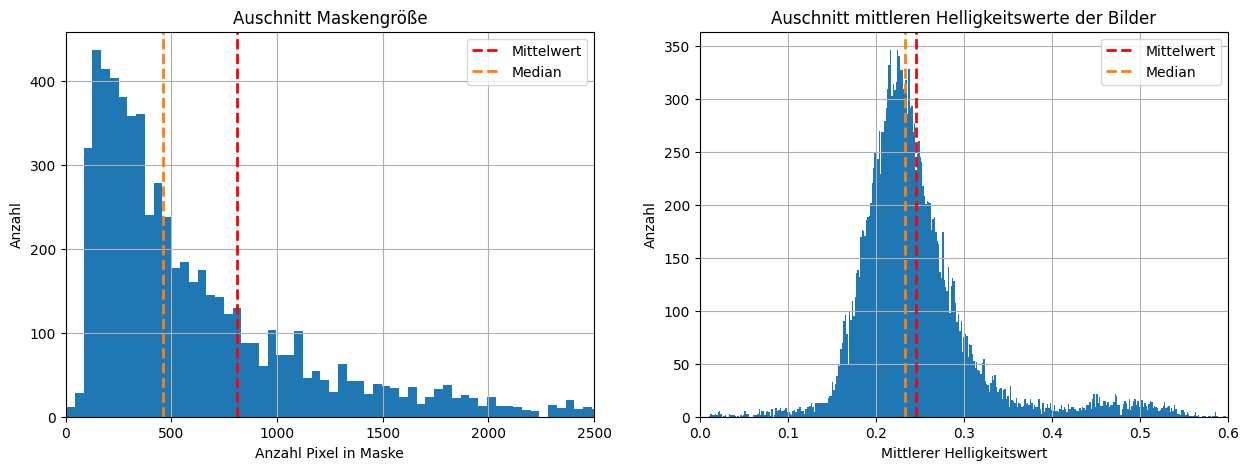

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.hist(mask_size_list, bins=500)
ax1.grid(True)
ax1.set_xlim(0, 2500)
ax1.set_xlabel('Anzahl Pixel in Maske')
ax1.set_ylabel('Anzahl')
ax1.set_title(f'Auschnitt Maskengröße')
ax1.axvline(mean_mask_size, color='r', linestyle='dashed', linewidth=2)
ax1.axvline(median_mask_size, color='tab:orange', linestyle='dashed', linewidth=2)
ax1.legend(['Mittelwert', 'Median'])

ax2.hist(avg_image_brightness_list, bins=400)
ax2.grid(True)
ax2.set_xlim(0, 0.60)
ax2.set_xlabel('Mittlerer Helligkeitswert')
ax2.set_ylabel('Anzahl')
ax2.set_title('Auschnitt mittleren Helligkeitswerte der Bilder')
ax2.axvline(mean_avg_brightness, color='r', linestyle='dashed', linewidth=2)
ax2.axvline(median_avg_brightness, color='tab:orange', linestyle='dashed', linewidth=2)
ax2.legend(['Mittelwert', 'Median'])
plt.show()

In [43]:
fig.savefig('figures/raw_data/histogram_mask_size_brightness.pdf', bbox_inches='tight')

In [96]:
df.sort_values(by=['avg_brightness'], inplace=True)

In [97]:
df.head()

,avg_brightness,file_path
17567,0.010605,C:\Users\Fabian\Documents\Github_Masterthesis\...
3968,0.012400,C:\Users\Fabian\Documents\Github_Masterthesis\...
10805,0.012461,C:\Users\Fabian\Documents\Github_Masterthesis\...
16132,0.012822,C:\Users\Fabian\Documents\Github_Masterthesis\...
16346,0.014125,C:\Users\Fabian\Documents\Github_Masterthesis\...


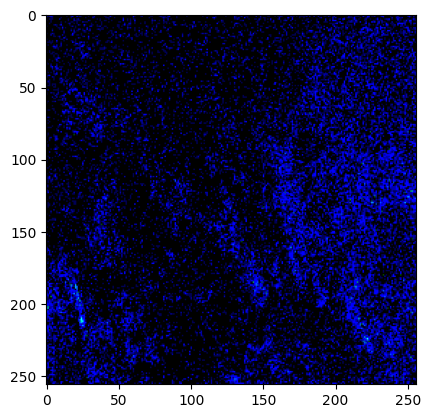

In [98]:
data = df.iloc[50, 1]
image = rasterio.open(data).read()[1:4, :, :].transpose(1, 2, 0)
plt.imshow(image);

In [100]:
image_with_high_reflectance = rasterio.open(df.iloc[80, 1]).read()[1:4].transpose(1, 2, 0)
avg_brightness_high_reflectance = df.iloc[80, 0]
image_with_high_cutoff = rasterio.open(df.iloc[45, 1]).read()[1:4].transpose(1, 2, 0)
avg_brightness_high_cutoff = df.iloc[45, 0]
image_with_water_distortion = rasterio.open(df.iloc[50, 1]).read()[1:4].transpose(1, 2, 0)
avg_brightness_water_distortion = df.iloc[50, 0]

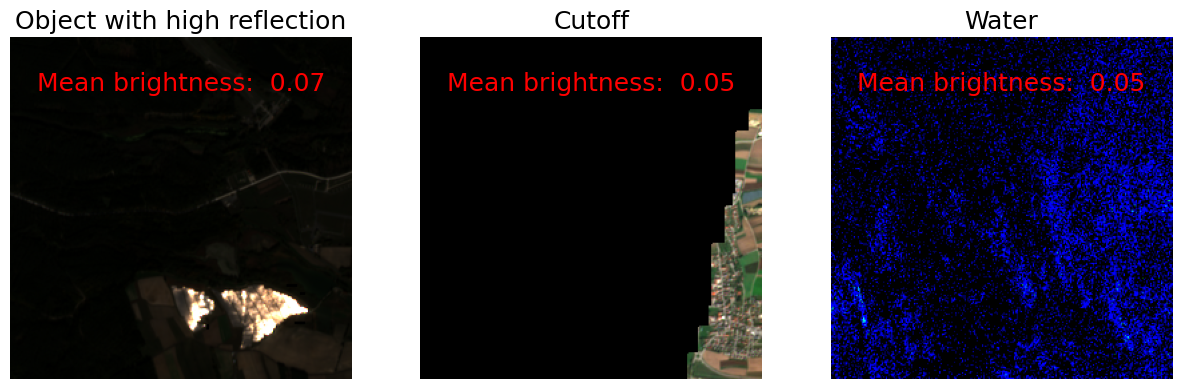

In [108]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(image_with_high_reflectance)
ax1.set_title('Object with high reflection', fontsize=18)
ax1.text(0.5, 0.9, f'Mean brightness: {avg_brightness_high_reflectance: .2f}', fontsize=18, horizontalalignment='center', verticalalignment='top', transform=ax1.transAxes, color='r')
ax1.axis('off')

ax2.imshow(image_with_high_cutoff)
ax2.set_title('Cutoff', fontsize=18)
ax2.text(0.5, 0.9, f'Mean brightness: {avg_brightness_high_cutoff: .2f}', fontsize=18, horizontalalignment='center', verticalalignment='top', transform=ax2.transAxes, color='r')
ax2.axis('off')

ax3.imshow(image_with_water_distortion)
ax3.set_title('Water', fontsize=18)
ax3.text(0.5, 0.9, f'Mean brightness: {avg_brightness_water_distortion: .2f}', fontsize=18, horizontalalignment='center', verticalalignment='top', transform=ax3.transAxes, color='r')
ax3.axis('off');

In [109]:
fig.savefig('figures/raw_data/low_brightness_examples_eng.pdf', bbox_inches='tight')
fig.savefig('figures/raw_data/low_brightness_examples_eng.svg', bbox_inches='tight')

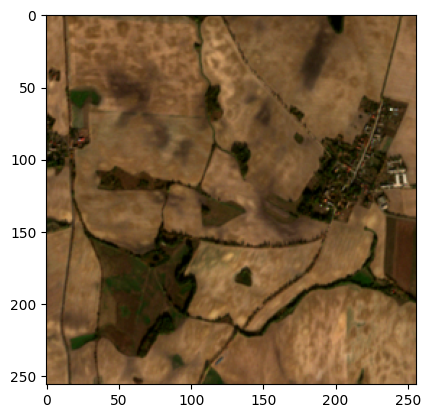

In [218]:
data = df.iloc[-950, 1]
image = rasterio.open(data).read()[1:4, :, :].transpose(1, 2, 0)
plt.imshow(image);

In [104]:
image_with_water_reflectance = rasterio.open(df.iloc[-1000, 1]).read()[1:4].transpose(1, 2, 0)
avg_brightness_water_reflectance = df.iloc[-1000, 0]
image_with_snow = rasterio.open(df.iloc[-1, 1]).read()[1:4].transpose(1, 2, 0)
avg_brightness_snow = df.iloc[-1, 0]
image_with_bright_crops = rasterio.open(df.iloc[-950, 1]).read()[1:4].transpose(1, 2, 0)
avg_brightness_bright_crops = df.iloc[-950, 0]

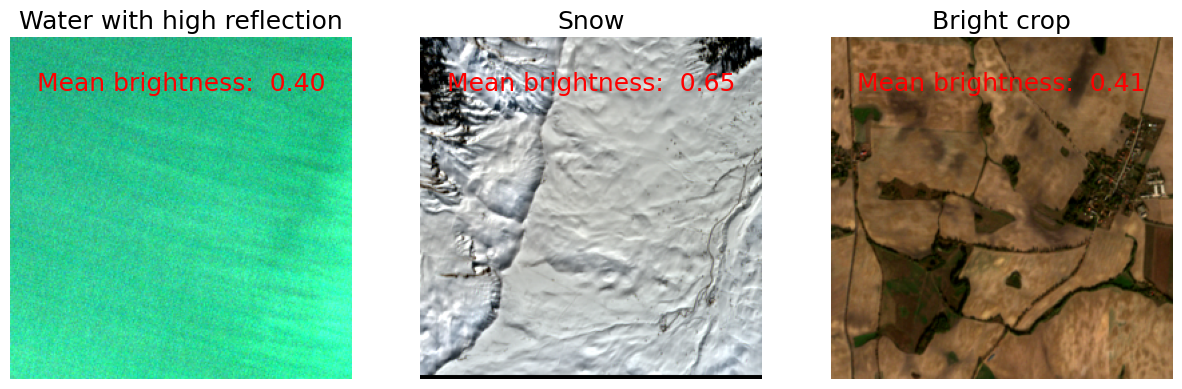

In [105]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(image_with_water_reflectance)
ax1.set_title('Water with high reflection', fontsize=18)
ax1.text(0.5, 0.9, f'Mean brightness: {avg_brightness_water_reflectance: .2f}', fontsize=18, horizontalalignment='center', verticalalignment='top', transform=ax1.transAxes, color='r')
ax1.axis('off')

ax2.imshow(image_with_snow)
ax2.set_title('Snow', fontsize=18)
ax2.text(0.5, 0.9, f'Mean brightness: {avg_brightness_snow: .2f}', fontsize=18, horizontalalignment='center', verticalalignment='top', transform=ax2.transAxes, color='r')
ax2.axis('off')

ax3.imshow(image_with_bright_crops)
ax3.set_title('Bright crop', fontsize=18)
ax3.text(0.5, 0.9, f'Mean brightness: {avg_brightness_bright_crops: .2f}', fontsize=18, horizontalalignment='center', verticalalignment='top', transform=ax3.transAxes, color='r')
ax3.axis('off');


In [107]:
fig.savefig('figures/raw_data/high_brightness_examples_eng.pdf', bbox_inches='tight')
fig.savefig('figures/raw_data/high_brightness_examples_eng.svg', bbox_inches='tight')

### Create trainings data (sort them in train, validation and test set) and convert them to tensors (.pt files)

In [3]:
images_prepro_path = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\images_undersampling')
masks_prepro_path = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\masks_undersampling')

In [4]:
# create a list of all tiles
tile_list = []
for file_path in images_prepro_path.glob("*.tif"):
    filename = file_path.stem
    tile, number, date = filename.split("_")
    tile_list.append(tile)

# set is used to get unique values of tiles
tiles_unique = list(set(tile_list))

In [5]:
print(f'Number of tiles: {len(tiles_unique)}')

Number of tiles: 56


In [6]:
# select random tiles for train, val and test
random.seed(42)
random.shuffle(tiles_unique)

num_total = len(tiles_unique)
num_train = int(num_total * 0.7)
num_val = int(num_total * 0.2)

In [7]:
# create train, val and test list
train_list = tiles_unique[:num_train]
val_list = tiles_unique[num_train : num_train + num_val]
test_list = tiles_unique[num_train + num_val :]

In [8]:
print("Number of tiles in each set:")
print(f'Train: {len(train_list)}')
print(f'Val: {len(val_list)}')
print(f'Test: {len(test_list)}')

Number of tiles in each set:
Train: 39
Val: 11
Test: 6


In [3]:
# create a directory for each set
data_dir = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\data_splitted_undersampling')
for set_name in ["train", "val", "test"]:
    os.makedirs(data_dir / set_name, exist_ok=True)
    os.makedirs(data_dir / set_name / "images", exist_ok=True)
    os.makedirs(data_dir / set_name / "masks", exist_ok=True)

In [42]:
num_files = len(list(images_prepro_path.glob("*.tif")))
for file in tqdm(images_prepro_path.glob("*.tif"), total=num_files):
    file_stammed = file.stem
    filename = file.name
    tile, _, _ = file_stammed.split("_")

    image_path = images_prepro_path / filename
    mask_path = masks_prepro_path / filename
    
    image = rasterio.open(image_path).read()
    mask = rasterio.open(mask_path).read()
    
    image_tensor = torch.from_numpy(image)
    mask_tensor = torch.from_numpy(mask)

    if tile in train_list:
        torch.save(image_tensor, data_dir / "train" / "images" / f"{file_stammed}.pt")
        torch.save(mask_tensor, data_dir / "train" / "masks" / f"{file_stammed}.pt")
    elif tile in val_list:
        torch.save(image_tensor, data_dir / "val" / "images" / f"{file_stammed}.pt")
        torch.save(mask_tensor, data_dir / "val" / "masks" / f"{file_stammed}.pt")
    elif tile in test_list:
        torch.save(image_tensor, data_dir / "test" / "images" / f"{file_stammed}.pt")
        torch.save(mask_tensor, data_dir / "test" / "masks" / f"{file_stammed}.pt")
    else:
        print("Error: Tile not in any set!")

  0%|          | 0/20683 [00:00<?, ?it/s]

100%|██████████| 20683/20683 [09:50<00:00, 35.03it/s]


In [47]:
# check if all files are copied
print("Number of files in each set:")
print(f'Train images: {len(list(data_dir.glob("train/images/*.pt")))}')
print(f'Train masks: {len(list(data_dir.glob("train/masks/*.pt")))}')
print(f'Val images: {len(list(data_dir.glob("val/images/*.pt")))}')
print(f'Val masks: {len(list(data_dir.glob("val/masks/*.pt")))}')
print(f'Test images: {len(list(data_dir.glob("test/images/*.pt")))}')
print(f'Test masks: {len(list(data_dir.glob("test/masks/*.pt")))}')

Number of files in each set:
Train images: 14178
Train masks: 14178
Val images: 4648
Val masks: 4648
Test images: 1857
Test masks: 1857


### Create cleaned data set

In [80]:
# create a directory for each set
data_dir_cleaned = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\data_splitted_undersampling_cleaned')
for set_name in ["train", "val", "test"]:
    os.makedirs(data_dir_cleaned / set_name, exist_ok=True)
    os.makedirs(data_dir_cleaned / set_name / "images", exist_ok=True)
    os.makedirs(data_dir_cleaned / set_name / "masks", exist_ok=True)
    os.makedirs(data_dir_cleaned / "upload", exist_ok=True)

In [11]:
for set_name in ["train", "val", "test"]:
    image_path = data_dir / set_name / "images"
    mask_path = data_dir / set_name / "masks"
    for file in image_path.glob("*.pt"):
        image_file_path = image_path / file.name
        mask_file_path = mask_path / file.name
        image = torch.load(image_file_path)
        mask = torch.load(mask_file_path)
        
        if mask.sum() > 0 and mask.sum() <= 400:
            continue

        if image.mean() < 0.1:
            continue
        
        torch.save(image, data_dir_cleaned / set_name / "images" / file.name)
        torch.save(mask, data_dir_cleaned / set_name / "masks" / file.name)

In [12]:
# check if all files are copied
print("Number of files in each set:")
print(f'Train images: {len(list(data_dir_cleaned.glob("train/images/*.pt")))}')
print(f'Train masks: {len(list(data_dir_cleaned.glob("train/masks/*.pt")))}')
print(f'Val images: {len(list(data_dir_cleaned.glob("val/images/*.pt")))}')
print(f'Val masks: {len(list(data_dir_cleaned.glob("val/masks/*.pt")))}')
print(f'Test images: {len(list(data_dir_cleaned.glob("test/images/*.pt")))}')
print(f'Test masks: {len(list(data_dir_cleaned.glob("test/masks/*.pt")))}')

Number of files in each set:
Train images: 12062
Train masks: 12062
Val images: 3997
Val masks: 3997
Test images: 1614
Test masks: 1614


### Create a folder from cleaned data set from .tif files to upload them to aws s3

But only the train, validation and test set with a solar park in the picture. Late it will be possible to use the whole data set. But sort it with a confidence score.

In [82]:
upload_source = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\images_undersampling\upload')

for set_name in ["train", "val", "test"]:
    counter = 0
    mask_path = data_dir_cleaned / set_name / "masks"
    for file in mask_path.glob("*.pt"):
        mask_file_path = mask_path / file.name
        mask = torch.load(mask_file_path)
        
        if mask.sum() < 400:
            continue
        image_file_path = upload_source / f"{file.stem}.tif"
        shutil.copyfile(image_file_path, data_dir_cleaned / "upload" / f"{file.stem}.tif")
        counter += 1
    print(f"Number of files with solarpark in {set_name}: {counter}")

Number of files with solarpark in train: 2418
Number of files with solarpark in val: 979
Number of files with solarpark in test: 219


### Create geojson file 

In [2]:
import geopandas as gpd
import rasterio.features
import numpy as np
from typing import Tuple, List
from shapely.geometry import Polygon
from rasterio.warp import transform_geom
from rasterio.features import geometry_mask
from datetime import datetime


In [4]:
# strucutre of geojson
gdf = gpd.read_file(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\geojsons\solar-parks.geojson')
gdf.head()

,avg_confidence,comment,date_of_data,first_detection,is_valid,last_detection,name_in_aws,name_of_model,peak_power,size_in_sq_m,geometry
0,0.0,None,2023-05-09,2023-05-09,non-valid,2023-05-09,32UPC_20_2023-5-9.tif,solar-park-detection,3.088,19300.0,"POLYGON ((11.20714 52.31969, 11.20787 52.31968..."
1,0.0,None,2023-05-09,2023-05-09,non-valid,2023-05-09,32UPC_20_2023-5-9.tif,solar-park-detection,4.512,28200.0,"POLYGON ((11.20472 52.31821, 11.20530 52.31820..."
2,0.0,None,2023-05-09,2023-05-09,valid,2023-05-09,32UPC_31_2023-5-9.tif,solar-park-detection,2.384,14900.0,"POLYGON ((11.61811 52.32361, 11.61870 52.32360..."
3,0.0,None,2023-05-09,2023-05-09,valid,2023-05-09,32UPC_33_2023-5-9.tif,solar-park-detection,4.672,29200.0,"POLYGON ((11.68509 52.30520, 11.68568 52.30519..."
4,0.0,None,2023-05-09,2023-05-09,non-valid,2023-05-09,32UPC_193_2023-5-9.tif,solar-park-detection,1.408,8800.0,"POLYGON ((11.09063 52.23873, 11.09060 52.23810..."


In [21]:
def masks_to_polygons(
    masks: np.ndarray, metadata: dict
) -> Tuple[List[Polygon], List[float]]:
    masks = masks.astype(np.uint8)
    transform = metadata["transform"]
    crs = metadata["crs"]
    # extract shapes
    shapes = rasterio.features.shapes(masks, transform=transform)
    polygons = []
    areas = []
    peak_powers = []
    for shape in shapes:
        if shape[1] == 1:
            polygon = Polygon(shape[0]["coordinates"][0])
            area = polygon.area
            # realistically, the smallest solar park should be bigger than 10.000 m²
            if area >= 0:
                # Transform the polygon coordinates to EPSG:4326
                transformed_geom = transform_geom(
                    crs, "EPSG:4326", polygon.__geo_interface__
                )
                transformed_coords = transformed_geom["coordinates"][0]
                transformed_polygon = Polygon(transformed_coords)
                peak_power = calc_peak_power(area_in_sq_m=area)
                polygons.append(transformed_polygon)
                areas.append(area)
                peak_powers.append(peak_power)
    return polygons, areas, peak_powers

In [20]:
def calc_peak_power(area_in_sq_m: float) -> float:
    # Solar park in 2015
    # https://www.bundesnetzagentur.de/SharedDocs/Downloads/DE/Sachgebiete/Energie/Unternehmen_Institutionen/ErneuerbareEnergien/PV-Freiflaechenanlagen/Bericht_Flaecheninanspruchnahme_2016.pdf?__blob=publicationFile&v=2#:~:text=Die%20bereits%20im%20Rahmen%20der,Ackerland%20in%20benachteiligten%20Gebieten%20errichtet. # noqa
    # page 8 on the pdf (german)
    # 1,6 acre = 1 MWp
    # Solar park in 2022
    # https://www.ise.fraunhofer.de/content/dam/ise/de/documents/publications/studies/aktuelle-fakten-zur-photovoltaik-in-deutschland.pdf
    # page 40 on the pdf (german)
    # 1 MWP/ha, 980 MWh/MWP
    # => 1 acre = 10000 m² = 1 MWp
    return area_in_sq_m / 10000

In [30]:
data_dir_cleaned = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\data_splitted_undersampling_cleaned')
mask_dir = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\masks_undersampling')
polygons_list = []
areas_list = []
peak_powers_list = []
filenames_list = []
set_name_list = []
for set_name in ["train", "val", "test"]:
    mask_path = data_dir_cleaned / set_name / "masks"
    for file_path in mask_path.glob("*.pt"):
        filename = file_path.stem
        mask = rasterio.open(mask_dir / f"{filename}.tif").read()
        metadata   = rasterio.open(mask_dir / f"{filename}.tif").meta
        if mask.sum() > 0:
            polygons, areas, peak_powers = masks_to_polygons(mask, metadata)
            polygons_list.extend(polygons)
            areas_list.extend(areas)
            peak_powers_list.extend(peak_powers)
            for i in range(len(polygons)):
                filenames_list.append(f"{filename}.tif")
                set_name_list.append(set_name)

In [77]:
gdf.columns

Index(['avg_confidence', 'comment', 'date_of_data', 'first_detection',
       'is_valid', 'last_detection', 'name_in_aws', 'name_of_model',
       'peak_power', 'size_in_sq_m', 'geometry'],
      dtype='object')

In [31]:
print(f"Number of polygons: {len(polygons_list)}")
print(f"Number of areas: {len(areas_list)}")
print(f"Number of peak powers: {len(peak_powers_list)}")
print(f"Number of filenames: {len(filenames_list)}")
print(f"Number of set names: {len(set_name_list)}")

Number of polygons: 6305
Number of areas: 6305
Number of peak powers: 6305
Number of filenames: 6305
Number of set names: 6305


In [213]:
date_string = "2018-01-01"
date_obj = datetime.strptime(date_string, "%Y-%m-%d").date()
data = {
    "name_of_model": set_name_list,
    "size_in_sq_m": areas_list,
    "peak_power": peak_powers_list,
    "date_of_data": '2018-01-01',
    "first_detection": '2018-01-01',  # will be handled on api level
    "last_detection": '2018-01-01',  # will be handled on api level
    "avg_confidence": 0,
    "name_in_aws": filenames_list,
    "is_valid": "None",
    "comment": set_name_list,
    "geometry": polygons_list
}
df = gpd.GeoDataFrame(data, crs="EPSG:4326")

In [122]:
# small polygons are in the dataset, again, because the masks are still in the mask file
df.sort_values(by=['size_in_sq_m'], ascending=True).head()

,name_of_model,size_in_sq_m,peak_power,date_of_data,first_detection,last_detection,avg_confidence,name_in_aws,is_valid,comment,geometry
1670,train,100.0,0.01,2018-01-01,2018-01-01,2018-01-01,0,32UPB_248_2018-10-14.tif,None,train,"POLYGON ((11.42227 51.29745, 11.42227 51.29736..."
4297,val,100.0,0.01,2018-01-01,2018-01-01,2018-01-01,0,32UMV_773_2018-9-27.tif,None,val,"POLYGON ((8.49403 49.25350, 8.49403 49.25341, ..."
4272,val,100.0,0.01,2018-01-01,2018-01-01,2018-01-01,0,32UMV_773_2018-7-9.tif,None,val,"POLYGON ((8.49403 49.25350, 8.49403 49.25341, ..."
1674,train,100.0,0.01,2018-01-01,2018-01-01,2018-01-01,0,32UPB_248_2018-5-7.tif,None,train,"POLYGON ((11.42227 51.29745, 11.42227 51.29736..."
4247,val,100.0,0.01,2018-01-01,2018-01-01,2018-01-01,0,32UMV_773_2018-5-5.tif,None,val,"POLYGON ((8.49403 49.25350, 8.49403 49.25341, ..."


In [214]:
print(f"Number of polygons: {len(df)}")
df = df[df['size_in_sq_m'] > 40000]
print(f"Number of polygons after cleaning: {len(df)}")

Number of polygons: 6305
Number of polygons after cleaning: 3987


In [145]:
df["name_of_model"].value_counts()

name_of_model
training      2614
validation    1136
test           237
Name: count, dtype: int64

In [127]:
df['name_of_model'].replace({'train': 'training', 'val': 'validation'}, inplace=True)

In [112]:
df = df.set_geometry('geometry')

df.to_file('Trainingsdata_not_verified.geojson', driver='GeoJSON')

In [6]:
df = gpd.read_file('Trainingsdata_not_verified.geojson')

In [125]:
df.geometry.nunique()

1324

In [75]:
unique_df = df.drop_duplicates(subset=['geometry'], keep='first')

In [76]:
len(unique_df)

1324

In [77]:
unique_df.sort_values(by=['size_in_sq_m'], ascending=True).head()

,name_of_model,size_in_sq_m,peak_power,date_of_data,first_detection,last_detection,avg_confidence,name_in_aws,is_valid,comment,geometry
608,training,40100.0,4.01,2018-01-01,2018-01-01,2018-01-01,0,32UMU_1480_2018-10-14.tif,None,train,"POLYGON ((8.60176 47.99427, 8.60243 47.99427, ..."
3323,training,40100.0,4.01,2018-01-01,2018-01-01,2018-01-01,0,32UQV_1429_2018-10-11.tif,None,train,"POLYGON ((12.43529 48.85582, 12.43570 48.85581..."
2389,training,40100.0,4.01,2018-01-01,2018-01-01,2018-01-01,0,32UQA_401_2018-7-3.tif,None,train,"POLYGON ((11.97805 50.28867, 11.97875 50.28865..."
5870,validation,40100.0,4.01,2018-01-01,2018-01-01,2018-01-01,0,33UVU_1237_2018-10-14.tif,None,val,"POLYGON ((13.69980 52.59956, 13.70024 52.59956..."
2933,training,40100.0,4.01,2018-01-01,2018-01-01,2018-01-01,0,32UQD_261_2018-10-14.tif,None,train,"POLYGON ((13.54411 53.02956, 13.54426 53.02956..."


In [78]:
unique_df.to_file('Trainingsdata_not_verified_unique.geojson', driver='GeoJSON')

### Check verified dataset

In [3]:
df_unique_classified = gpd.read_file('solar-parks_classified.geojson')

In [4]:
df_unique_classified.set_geometry('geometry')
df_unique_classified.head()

,avg_confidence,comment,date_of_data,first_detection,is_valid,last_detection,name_in_aws,name_of_model,peak_power,size_in_sq_m,geometry
0,0.0,train,2018-01-01,2018-01-01,valid,2018-01-01,32UQE_1587_2018-10-14.tif,training,5.93,59300.0,"POLYGON ((12.09902 53.27578, 12.09947 53.27577..."
1,0.0,train,2018-01-01,2018-01-01,valid,2018-01-01,32UQE_290_2018-10-14.tif,training,4.21,42100.0,"POLYGON ((13.04326 53.92381, 13.04341 53.92380..."
2,0.0,train,2018-01-01,2018-01-01,valid,2018-01-01,31UGR_1028_2018-10-10.tif,training,5.63,56300.0,"POLYGON ((6.35119 49.97118, 6.35175 49.97116, ..."
3,0.0,train,2018-01-01,2018-01-01,valid,2018-01-01,31UGR_1125_2018-10-10.tif,training,6.69,66900.0,"POLYGON ((6.64335 49.91279, 6.64349 49.91278, ..."
4,0.0,train,2018-01-01,2018-01-01,valid,2018-01-01,31UGR_1166_2018-10-10.tif,training,6.81,68100.0,"POLYGON ((6.56050 49.89089, 6.56189 49.89085, ..."


In [7]:
len(df)

3987

In [8]:
# merging doesn't work on the geometry column therefore we need to convert it to a string and merge it on the string column
df['geometry_str'] = df.geometry.astype(str).copy()
df_unique_classified['geometry_str'] = df_unique_classified.geometry.astype(str).copy()

In [9]:
merged = df.merge(df_unique_classified[['geometry_str', 'is_valid']], on='geometry_str', how='left')

In [20]:
len(merged)

3987

### Proof that there is not Data Leakage

In [12]:
df_subset = df[['name_of_model', 'geometry_str']].copy()

In [15]:
df_subset_train = df_subset[df_subset['name_of_model'] == 'training']
df_subset_val = df_subset[df_subset['name_of_model'] == 'validation']
df_subset_test = df_subset[df_subset['name_of_model'] == 'test']

In [22]:
train_val = df_subset_train.merge(df_subset_val, on='geometry_str', how='left')
train_test = df_subset_train.merge(df_subset_test, on='geometry_str', how='left')
train_train = df_subset_train.merge(df_subset_train, on='geometry_str', how='left')

In [24]:
train_train.name_of_model_y.value_counts()

name_of_model_y
training    8560
Name: count, dtype: int64

In [20]:
train_val.name_of_model_y.value_counts()

Series([], Name: count, dtype: int64)

In [26]:
train_test.name_of_model_y.value_counts()

Series([], Name: count, dtype: int64)

### End of Proof

In [13]:
unique_geom_count = df_subset.groupby('name_of_model')['geometry_str'].nunique()

In [14]:
diff_geom_groups = unique_geom_count[unique_geom_count > 1]

# Geben Sie die Namen der Modellgruppen aus, in denen sich Geometrien in unterschiedlichen Modellnamen befinden
if len(diff_geom_groups) > 0:
    print('Geometrien in unterschiedlichen Modellnamen gefunden:')
    print(diff_geom_groups)
else:
    print('Keine Geometrien in unterschiedlichen Modellnamen gefunden.')

Geometrien in unterschiedlichen Modellnamen gefunden:
name_of_model
test           74
training      894
validation    356
Name: geometry_str, dtype: int64


In [75]:
merged.head()

,name_of_model,size_in_sq_m,peak_power,date_of_data,first_detection,last_detection,avg_confidence,name_in_aws,comment,geometry,is_valid_y
0,training,154800.0,15.48,2018-01-01,2018-01-01,2018-01-01,0,31UGR_1011_2018-10-10.tif,train,"POLYGON ((7.28512 49.95173, 7.28553 49.95172, ...",unsure
1,training,154800.0,15.48,2018-01-01,2018-01-01,2018-01-01,0,31UGR_1011_2018-4-20.tif,train,"POLYGON ((7.28512 49.95173, 7.28553 49.95172, ...",unsure
2,training,154800.0,15.48,2018-01-01,2018-01-01,2018-01-01,0,31UGR_1011_2018-7-2.tif,train,"POLYGON ((7.28512 49.95173, 7.28553 49.95172, ...",unsure
3,training,154800.0,15.48,2018-01-01,2018-01-01,2018-01-01,0,31UGR_1011_2018-9-27.tif,train,"POLYGON ((7.28512 49.95173, 7.28553 49.95172, ...",unsure
4,training,56300.0,5.63,2018-01-01,2018-01-01,2018-01-01,0,31UGR_1028_2018-10-10.tif,train,"POLYGON ((6.35119 49.97118, 6.35175 49.97116, ...",valid


In [76]:
merged.drop(columns=['geometry_str', 'is_valid_x'], inplace=True)
merged.rename(columns={'is_valid_y': 'is_valid'}, inplace=True)
merged_cleaned = merged[merged['is_valid'] == 'valid']

In [78]:
merged_cleaned[['name_of_model', 'is_valid']].groupby('name_of_model').count()

,is_valid
name_of_model,
test,231
training,2391
validation,1121


In [83]:
merged_cleaned.to_file('Trainingsdata_verified.geojson', driver='GeoJSON')

### Create a cleaned and verified dataset 

In [ ]:
data_dir_cleaned_verified = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\data_splitted_undersampling_cleaned_verified')
for set_name in ["train", "val", "test"]:
    (data_dir_cleaned_verified / set_name).mkdir(exist_ok=True, parents=True)
    os.makedirs(data_dir_cleaned_verified / set_name / "images", exist_ok=True)
    os.makedirs(data_dir_cleaned_verified / set_name / "masks", exist_ok=True)
    os.makedirs(data_dir_cleaned_verified / "upload", exist_ok=True)

In [101]:
merged_cleaned = gpd.read_file('Trainingsdata_verified.geojson')
data_dir_cleaned = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\data_splitted_undersampling_cleaned')
image_tif_dir = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\images_undersampling')
for set_name in ["train", "val", "test"]:
    image_dir = data_dir_cleaned / set_name / "images"
    mask_dir = data_dir_cleaned / set_name/ "masks"
    image_dir_verified = data_dir_cleaned_verified / set_name / "images"
    mask_dir_verified = data_dir_cleaned_verified / set_name / "masks"

    for file_path in mask_dir.glob("*.pt"):
        filename_stemmed = file_path.stem

        mask = torch.load(mask_dir / f"{filename_stemmed}.pt")
        if mask.sum() == 0:
            # copy image and mask to new directory    
            shutil.copyfile(image_dir / f"{filename_stemmed}.pt", image_dir_verified / f"{filename_stemmed}.pt")
            shutil.copyfile(mask_dir / f"{filename_stemmed}.pt", mask_dir_verified / f"{filename_stemmed}.pt")
            continue
        
        # check if mask is in the geojson
        filename = f"{filename_stemmed}.tif"
        if filename not in merged_cleaned['name_in_aws'].values:
            continue
        shutil.copyfile(image_dir/ f"{filename_stemmed}.pt", image_dir_verified / f"{filename_stemmed}.pt")
        shutil.copyfile(mask_dir / f"{filename_stemmed}.pt", mask_dir_verified / f"{filename_stemmed}.pt")

In [102]:
# check if all files are copied
print("Number of files in each set:")
print(f'Train images: {len(list(data_dir_cleaned_verified.glob("train/images/*.pt")))}')
print(f'Train masks: {len(list(data_dir_cleaned_verified.glob("train/masks/*.pt")))}')
print(f'Val images: {len(list(data_dir_cleaned_verified.glob("val/images/*.pt")))}')
print(f'Val masks: {len(list(data_dir_cleaned_verified.glob("val/masks/*.pt")))}')
print(f'Test images: {len(list(data_dir_cleaned_verified.glob("test/images/*.pt")))}')
print(f'Test masks: {len(list(data_dir_cleaned_verified.glob("test/masks/*.pt")))}')

Number of files in each set:
Train images: 11703
Train masks: 11703
Val images: 3899
Val masks: 3899
Test images: 1595
Test masks: 1595


## Old Code below

In [97]:
def rasterize_mask(masks: gpd.GeoDataFrame, metadata: dict) -> np.ndarray:
    # create a raster which matches the image shape
    # invert=True masked pixels set to True (instead of the other way around)
    # all_touched=True all pixels within the mask set to True (instead of the bounds)
    crs = metadata["crs"]
    shape = (metadata["height"], metadata["width"])
    transform = metadata["transform"]
    return geometry_mask(
        geometries=masks.to_crs(crs),
        out_shape=shape,
        transform=transform,
        all_touched=True,
        invert=True,
    )

def save_patch(output_path: Path, metadata: dict, data: np.ndarray) -> bool:
    metadata["driver"] = "GTiff"
    # ! add folder for masks and images
    output_path.parent.mkdir(parents=True, exist_ok=True)
   
    with rasterio.open(fp=output_path, mode="w", **metadata) as dst:
        dst.write(data)

    return True

In [100]:
data_dir_cleaned_verified = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\data_splitted_undersampling_cleaned_verified')
for set_name in ["train", "val", "test"]:
    (data_dir_cleaned_verified / set_name).mkdir(exist_ok=True, parents=True)
    os.makedirs(data_dir_cleaned_verified / set_name / "images", exist_ok=True)
    os.makedirs(data_dir_cleaned_verified / set_name / "masks", exist_ok=True)
    os.makedirs(data_dir_cleaned_verified / "upload", exist_ok=True)

In [99]:
merged_cleaned = gpd.read_file('Trainingsdata_verified.geojson')
data_dir_cleaned = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\data_splitted_undersampling_cleaned')
image_tif_dir = Path(r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\images_undersampling')
for set_name in ["train", "val", "test"]:
    image_dir = data_dir_cleaned / set_name / "images"
    mask_dir = data_dir_cleaned / set_name/ "masks"
    image_dir_verified = data_dir_cleaned_verified / set_name / "images"
    mask_dir_verified = data_dir_cleaned_verified / set_name / "masks"

    for file_path in mask_dir.glob("*.pt"):
        filename_stemmed = file_path.stem

        mask = torch.load(mask_dir / f"{filename_stemmed}.pt")
        if mask.sum() == 0:
            # copy image and mask to new directory    
            shutil.copyfile(image_dir / f"{filename_stemmed}.pt", image_dir_verified / f"{filename_stemmed}.pt")
            shutil.copyfile(mask_dir / f"{filename_stemmed}.pt", mask_dir_verified / f"{filename_stemmed}.pt")
            continue
        
        # check if mask is in the geojson
        filename = f"{filename_stemmed}.tif"
        if filename not in merged_cleaned['name_in_aws'].values:
            continue

        # create a rasterized mask
        metadata = rasterio.open(image_tif_dir / f"{filename_stemmed}.tif").meta
        rasterized_mask = rasterize_mask(merged_cleaned, metadata)
        if not rasterized_mask.sum() >= 400:
            continue
        expanded_mask = np.expand_dims(rasterized_mask, axis=0)
        mask_tensor = torch.from_numpy(expanded_mask)
        torch.save(mask_tensor, mask_dir_verified / f"{filename_stemmed}.pt")
        shutil.copyfile(image_dir/ f"{filename_stemmed}.pt", image_dir_verified / f"{filename_stemmed}.pt")

c:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\.venv\lib\site-packages\rasterio\features.py:324: ShapeSkipWarning: Invalid or empty shape name_of_model at index 0 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
c:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\.venv\lib\site-packages\rasterio\features.py:324: ShapeSkipWarning: Invalid or empty shape size_in_sq_m at index 1 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
c:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\.venv\lib\site-packages\rasterio\features.py:324: ShapeSkipWarning: Invalid or empty shape peak_power at index 2 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
c:\Users\Fabian\Documents\Git

ValueError: No valid geometry objects found for rasterize

In [91]:
# check if all files are copied
print("Number of files in each set:")
print(f'Train images: {len(list(data_dir_cleaned_verified.glob("train/images/*.pt")))}')
print(f'Train masks: {len(list(data_dir_cleaned_verified.glob("train/masks/*.pt")))}')
print(f'Val images: {len(list(data_dir_cleaned_verified.glob("val/images/*.pt")))}')
print(f'Val masks: {len(list(data_dir_cleaned_verified.glob("val/masks/*.pt")))}')
print(f'Test images: {len(list(data_dir_cleaned_verified.glob("test/images/*.pt")))}')
print(f'Test masks: {len(list(data_dir_cleaned_verified.glob("test/masks/*.pt")))}')

Number of files in each set:
Train images: 11703
Train masks: 11703
Val images: 3899
Val masks: 3899
Test images: 1595
Test masks: 1595
